# Principal Component Analysis

In [299]:
# import packages
import pandas as pd 
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
plt.style.use('science')


In [300]:
# get lemmatized data: 
df = pd.read_csv("data/final_df.csv")
df = df[["party", "name", "pos_lemmas", "created_at"]]
#Subset bushfire tweets
df = df.loc[(df["pos_lemmas"].str.contains("bush-fire|bushfire")) & 
             (df["created_at"] > "2019-06-01") & (df["created_at"] < "2020-07-01")].reset_index(drop = True)


df = df.groupby(["party"]).agg({"pos_lemmas":' '.join}).reset_index() 

In [402]:
X = df["pos_lemmas"]
vectorizer = CountVectorizer(max_features=150) 
X = vectorizer.fit_transform(X) 

In [403]:
standardized_actor2type_frequency = pd.DataFrame(X.todense(), index=df["party"], columns=vectorizer.get_feature_names())
standardized_actor2type_frequency["sum"] = standardized_actor2type_frequency.sum(axis = 1)
standardized_actor2type_frequency = standardized_actor2type_frequency.loc[:,:"sum"].div(standardized_actor2type_frequency["sum"], axis=0)
standardized_actor2type_frequency = standardized_actor2type_frequency.drop(columns=["sum"])

In [404]:
X_scaled = standardized_actor2type_frequency.to_numpy()

In [405]:
## Option 2. Use the PCA implementation in Scikit-Learn: 
from sklearn.decomposition import PCA
n_actors = 6
# Instantiate the PCA class
pca = PCA(n_components=n_actors) 

# Return unstandardized PC scores (i.e. U@S from SVD)
raw_PC = pca.fit_transform(X_scaled * 100) 

# Get singular values
S = np.diag(pca.singular_values_)

# Get standardized PC scores
PC = raw_PC@np.linalg.inv(S)*np.sqrt(n_actors-1) 

# Scale PC scores
scaled_PC = PC / np.max(abs(PC), axis=0) 

# Obtain standardized term loadings (maps from PC to feature space)
L = pca.components_.T@S/np.sqrt(n_actors-1)

# Obtain word weights (maps from feature to PC space)
W = (pca.components_.T@np.linalg.inv(S))*np.sqrt(n_actors-1) # Get word weights (maps from feature to PC space)

# Get proportion of captured variance
explained_variance = pca.explained_variance_ratio_

In [406]:
components = pd.DataFrame(L, index=vectorizer.get_feature_names(), columns=['PC{}'.format(d) for d in range(1,L.shape[1]+1)])
cumulative_variance = np.cumsum(explained_variance)

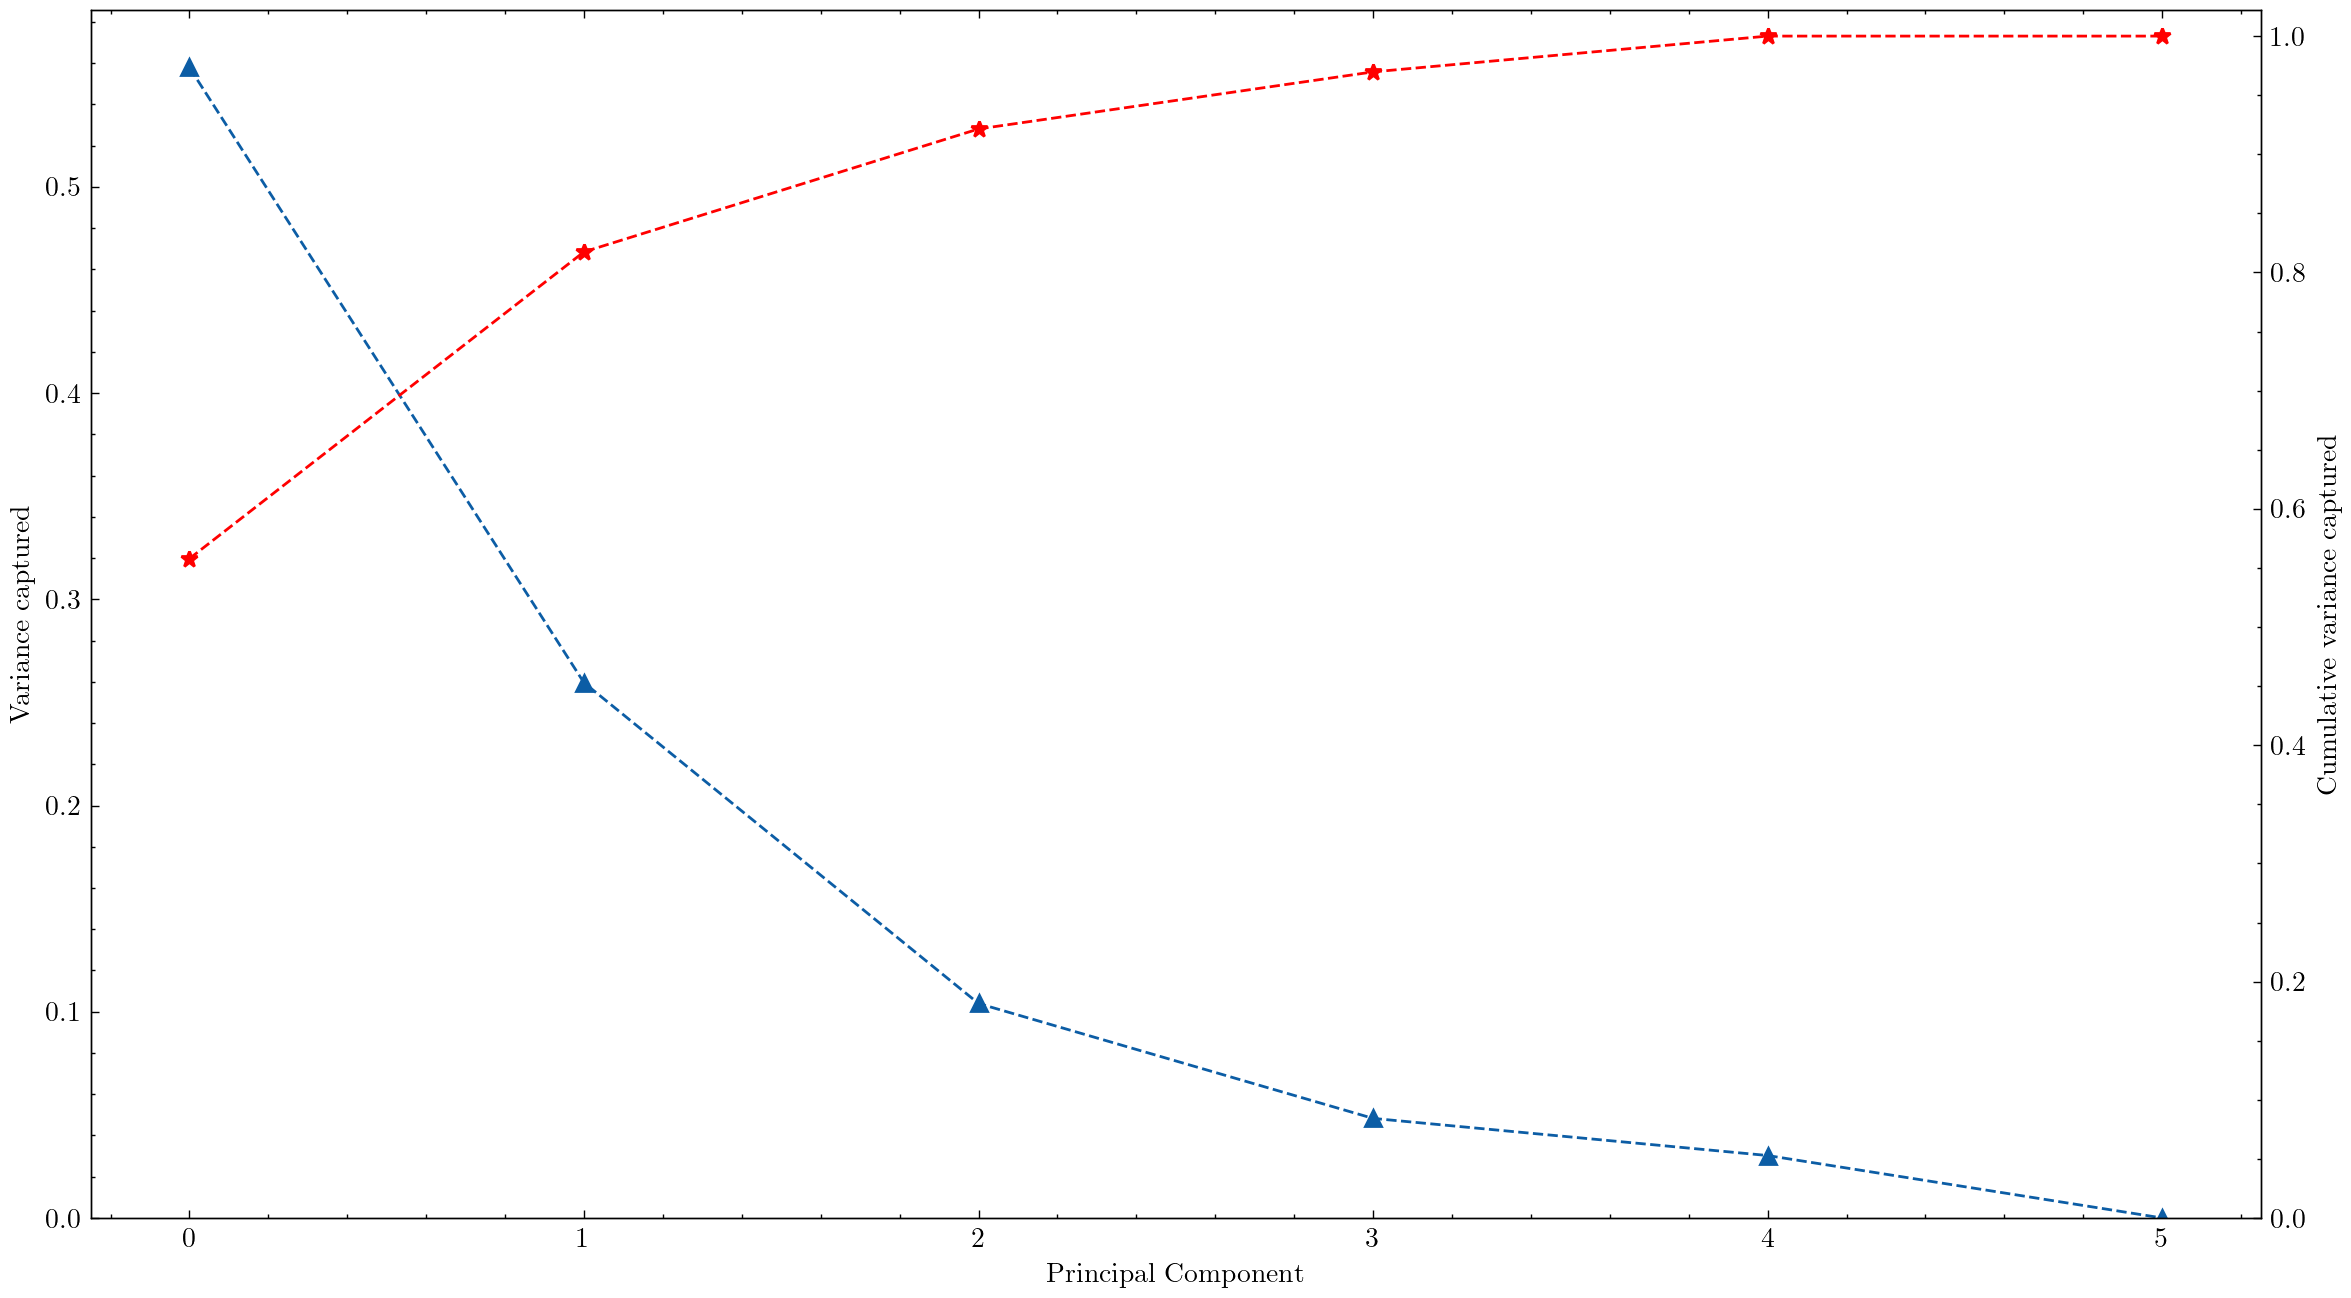

In [407]:
fig, ax = plt.subplots(1,1, figsize = (14,8), 
                       dpi=200)

# Plot the amount of variance captured by each principal components
sc1 = ax.plot(range(n_actors), explained_variance,'--^',label='Variance captured by each principal components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance captured')
ax.set_ylim(ymin=0)

# Plot the cumulative amount of variance captured on second y-axis
ax2 = ax.twinx()  # Create second y-axis
sc2 = ax2.plot(range(n_actors), cumulative_variance, 'r--*', label='Cumulative variance captured')
ax2.set_ylabel('Cumulative variance captured')
ax2.set_ylim(ymin=0)

#plt.legend([sc1, sc2], loc = 1)
plt.show()

In [408]:
# Determine how many words to plot in each direction
n_terms = 15

# Identify the indices that sorts the two first components
PCa_load_sidx = L[:,0].argsort()
PCb_load_sidx = L[:,1].argsort()

# Find the terms that load most on the first principal component
PCa_plot_idx = np.concatenate((PCa_load_sidx[:n_terms], PCa_load_sidx[-n_terms:]))

# Identify remaining indices
remain_idx = np.array([idx for idx in PCb_load_sidx if idx not in PCa_plot_idx])

# Find the remaining terms that load most on the second principal component
PCb_plot_idx = np.concatenate((remain_idx[:n_terms], remain_idx[-n_terms:]))

# Combine the indices
PC_plot_idx = np.unique(np.concatenate((PCa_plot_idx, PCb_plot_idx)))

# Get the term names
PC_plot_names = vectorizer.get_feature_names()#type_names[assoc_idx][PC_plot_idx]

# Get the term loadings
PC_plot_load = L[PC_plot_idx,:]

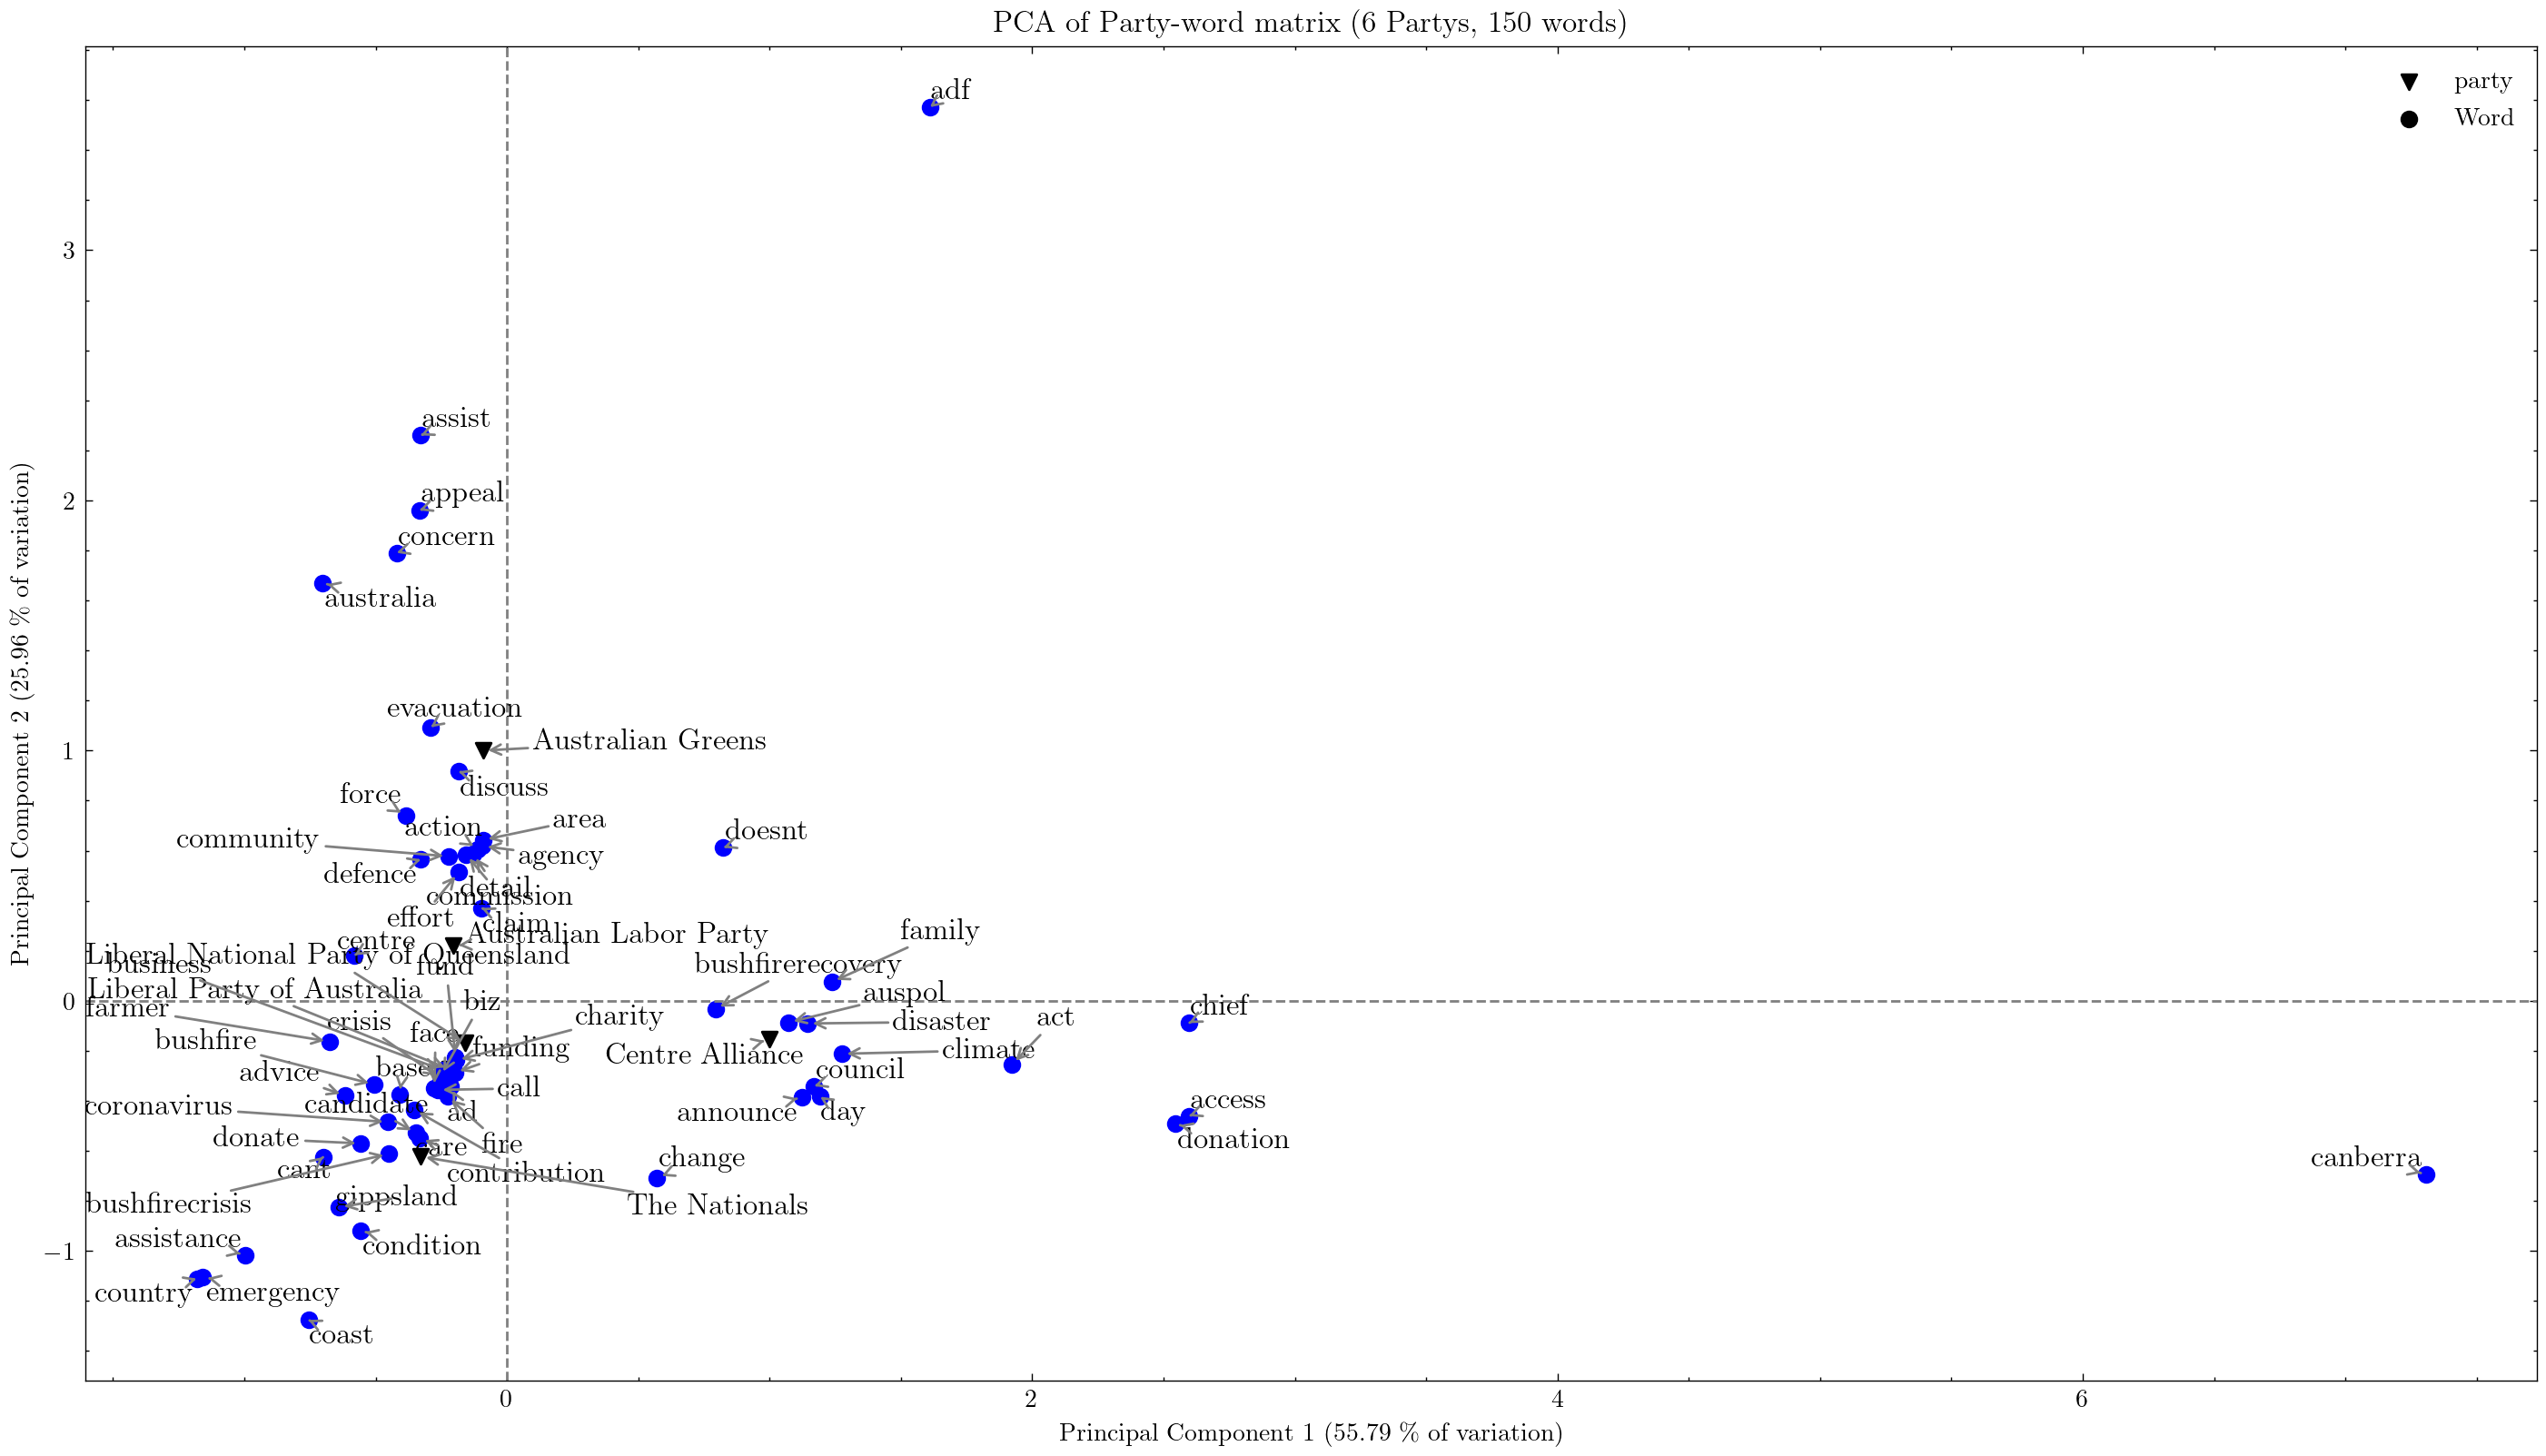

In [412]:
from adjustText import adjust_text
fig, ax = plt.subplots(1,1, figsize = (14,8), constrained_layout=True, dpi = 200)
actor_names = standardized_actor2type_frequency.index
# Title and label text 
ax.set_title('PCA of Party-word matrix ({} Partys, {} words)'.format(standardized_actor2type_frequency.shape[0],
                                                                 standardized_actor2type_frequency.shape[1],
                                                                 fontsize = 20,fontweight='bold'))
ax.set_xlabel(f'Principal Component 1 ({np.round(100*pca.explained_variance_ratio_[0], 2)} \% of variation)')
ax.set_ylabel(f'Principal Component 2 ({np.round(100*pca.explained_variance_ratio_[1], 2)} \% of variation)')

# Grid to mark zero loading             
ax.axvline(x=0, c='grey', linestyle='--')
ax.axhline(y=0, c='grey', linestyle='--')
       
# Plot standardized principal component scores
ax.scatter(scaled_PC[:,0], scaled_PC[:,1], marker = 'v', label='party', c='black')

# Plot word loadings
ax.scatter(PC_plot_load[:,0], PC_plot_load[:, 1], marker = 'o', label='Word', c='blue')

# Annotate the plot
texts = []
for x, y, txt in zip(scaled_PC[:,0], scaled_PC[:,1], actor_names):
    texts.append(plt.text(x, y, txt, size=12, weight='bold'))


for x, y, txt in zip(PC_plot_load[:,0], PC_plot_load[:,1], PC_plot_names):
    texts.append(plt.text(x, y, txt, size=12))

adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey')) # This part is slow

# Set legend to black
plt.legend()
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
          
plt.savefig("pca.png")    
plt.show()